In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import scipy
%matplotlib inline

In [13]:
# getting raw data
trial_data = []
debrief_data = []

for line in open('trials_data_p_all.json', 'r'):
    trial_data.append(json.loads(line))
for line in open('debriefs_data_p_all.json', 'r'):
    debrief_data.append(json.loads(line))

In [14]:
print(len(trial_data))

189


In [15]:
# transforming data into one dictionary with room as key and worker token_id as nested keys for their data
trial_data_room = {}
for trial in trial_data:
    id = trial["token_id"]
    room = trial["room"]
    if room not in trial_data_room.keys():
        trial_data_room[room] = {}
    if id not in trial_data_room[room].keys():
        trial_data_room[room][id] = []
    if trial not in trial_data_room[room][id]:
        trial_data_room[room][id].append(trial)

In [16]:
# checking how many workers completed the task together and computing their bonus. 
# appends details to a bash script that can be executed through aws from terminal  
boni = {}
rooms = list(trial_data_room.keys())
batch_results = pd.read_csv('batch_results_p_all.csv')
completion_pay = 3.50
# reduced data for participants that completed the task 
trial_data_completed = {}

# create bash script headline
with open ('bonus_results_p_all.sh', 'w') as rsh:
    bash = '''"#! /bin/bash"'''
    rsh.write(bash)
    
for room in rooms:
    if len(trial_data_room[room]) == 2:
        boni[room] = {}
        trial_data_completed[room] = {}
        tokens = list(trial_data_room[room].keys())
        for token in tokens:
            if len(trial_data_room[room][token]) == 5:
     
                boni[room][token] = 0
                trial_data_completed[room][token] = trial_data_room[room]
                for trial in range(0, len(trial_data_room[room][token])):
                    boni[room][token] += (sum(trial_data_room[room][token][trial]['posterior'][:4]) * 5 + (4 - sum(trial_data_room[room][token][trial]['posterior'][4:])))  / 100
                boni[room][token] = round(boni[room][token],2)
            
#                 location = batch_results[batch_results['Answer.surveycode']==token].index.item()
#                 print(token)
                
#                 worker_id = batch_results.loc[location, 'WorkerId']
#                 assignment_id = batch_results.loc[location, 'AssignmentId']
#                 bonus_amount = str(boni[room][token])
#                 total_bonus = str(boni[room][token] + completion_pay)
        
#                 with open ('bonus_results_p_all.sh', 'a') as rsh:
#                     bash ="\naws mturk send-bonus --worker-id " + worker_id + " --bonus-amount " + total_bonus + " --assignment-id " + assignment_id + " --reason  '$3.50 completion pay + " + "$" + bonus_amount + " bonus for your performance during the Challenging Science Game hit'"
#                     rsh.write(bash)
          

In [19]:
# creating a new data frame more convenient for analysis 
df_zendo = pd.DataFrame({"room": [], 
                         "token_id": [], 
                         "rule_name": [], 
                         "rule_description": [], 
                         "prior": [], 
                         "posterior": [], 
                         "prior_accuracy": [], 
                         "posterior_accuracy": [], 
                         "prior_feedback": [], 
                         "posterior_feedback": [],
                         "data": []})


# rule details 
rules = ["Rule1", "Rule2", "Rule3", "Rule4", "Rule5", "Rule6", "Rule7", "Rule8", "Rule9", "Rule10"]
rule_names = ['Zeta' ,'Phi' ,'Upsilon' ,'Iota' ,'Kappa' ,'Omega' ,'Mu' ,'Nu' ,'Xi', 'Psi']
rule_descriptions = ['there is a red', 
                     'they are all the same size', 
                     'none are upright', 
                     'one is blue', 
                     'at least one is blue AND small', 
                     'all are blue OR small',
                     'a red is bigger than all nonreds', 
                     'contact', 
                     'blue to red contact', 
                     'stacked']

ground_truth = [True,True,True,True,False,False,False,False]

for room in list(trial_data_completed.keys()):
    for token in list(trial_data_completed[room]):
        if len(trial_data_completed[room][token][token]) == 5:
            trial_index = 0
            for trial in trial_data_completed[room][token][token]:
                if list(trial_data_completed[room]).index(token) == 0:
                    partner_token = list(trial_data_completed[room])[1]
                    partner_trial = trial_data_completed[room][partner_token][partner_token][trial_index]
                else:
                    partner_token = list(trial_data_completed[room])[0]
                    partner_trial = trial_data_completed[room][partner_token][partner_token][trial_index]
                
                rule_name = trial['rule']
                rule_description = rule_descriptions[rule_names.index(rule_name)]
                prior = trial['prior']
                prior_partner = partner_trial['prior']
                posterior = trial['posterior']
                posterior_partner = partner_trial['posterior']
                prior_accuracy = (sum(prior[:4]) + (4 - sum(prior[4:]))) / len(prior)
                prior_accuracy_partner = (sum(partner_trial['prior'][:4]) + (4 - sum(partner_trial['prior'][4:]))) / len(partner_trial['prior'])
                posterior_accuracy = (sum(posterior[:4]) + (4 - sum(posterior[4:]))) / len(posterior)
                posterior_accuracy_partner = (sum(partner_trial['posterior'][:4]) + (4 - sum(partner_trial['posterior'][4:]))) / len(partner_trial['posterior'])
                prior_feedback = trial['ph4_answer']
                posterior_feedback = trial['ph5_answer']
                trustworthy_q = trial['trustworthy_q']
                expertise_q = trial['expertise_q']
                
                # getting stats on how generalisations of partner and subjects compare 
                prior_match = [a and b or not a and not b for a, b in zip(prior, partner_trial['prior'])]
                posterior_match = [a and b or not a and not b for a, b in zip(posterior, partner_trial['posterior'])]
                prior_match_perc = sum(prior_match) / len(prior_match)
                post_match_perc = sum(posterior_match) / len(posterior_match)
                prior_match_acc = sum([a and b and c or not a and not b and not c for a,b,c in zip(prior, partner_trial['prior'], ground_truth)]) / len(prior)
                post_match_acc = sum([a and b and c or not a and not b and not c for a,b,c in zip(posterior, partner_trial['posterior'], ground_truth)]) / len(prior)
                
                prior_alone_acc = sum([a and not b and c or not a and b and not c for a,b,c in zip(prior, partner_trial['prior'], ground_truth)]) / len(prior)
                post_alone_acc = sum([a and not b and c or not a and b and not c for a,b,c in zip(posterior, partner_trial['posterior'], ground_truth)]) / len(prior)
                prior_alone = [a and not b or not a and b for a,b in zip(prior, partner_trial['prior'])]
                posterior_alone = [a and not b or not a and b for a,b in zip(posterior, partner_trial['posterior'])]
                prior_alone_perc = sum(prior_alone) / len(prior_alone)
                post_alone_perc = sum(posterior_alone) / len(posterior_alone)
            
                # now checking how better player influenced the other player \n",
                if prior_accuracy >= prior_accuracy_partner:
                    delta_high_acc = posterior_accuracy - prior_accuracy
                    delta_low_acc = posterior_accuracy_partner - prior_accuracy_partner
                elif prior_accuracy < prior_accuracy_partner:
                    delta_high_acc = posterior_accuracy_partner - prior_accuracy_partner
                    delta_low_acc = posterior_accuracy - prior_accuracy

                prior_select_alone = [a and not b for a, b in zip(prior, partner_trial['prior'])]
                posterior_select_alone = [a and not b for a, b in zip(posterior, partner_trial['posterior'])]
                prior_select_other = [not a and b for a, b in zip(prior, partner_trial['prior'])]
                posterior_select_other = [not a and b for a, b in zip(posterior, partner_trial['posterior'])]
                accuracy_diff_prior = prior_accuracy - prior_accuracy_partner
                accuracy_diff_post = posterior_accuracy - posterior_accuracy_partner
                accuracy_change = prior_accuracy - posterior_accuracy
                accuracy_change_partner = prior_accuracy_partner - posterior_accuracy_partner
                data =  trial['data']
                
                
                df_zendo = df_zendo.append(pd.DataFrame({"room": [room], 
                                                         "token_id": [token], 
                                                         "rule_name": [rule_name], 
                                                         "rule_description": [rule_description], 
                                                         "prior": [prior], 
                                                         "prior_partner": [prior_partner],
                                                         "prior_match": [prior_match],
                                                         "prior_select_alone": [prior_select_alone],
                                                         "prior_select_other": [prior_select_other],
                                                         "posterior": [posterior], 
                                                         "posterior_partner": [posterior_partner],
                                                         "posterior_match": [posterior_match],
                                                         "posterior_select_alone": [posterior_select_alone],
                                                         "posterior_select_other": [posterior_select_other],
                                                         "prior_accuracy": [prior_accuracy], 
                                                         "posterior_accuracy": [posterior_accuracy], 
                                                         "prior_feedback": [prior_feedback], 
                                                         "posterior_feedback": [posterior_feedback],
                                                         "accuracy_diff_prior": [accuracy_diff_prior],
                                                         "accuracy_diff_post": [accuracy_diff_post],
                                                         "accuracy_change": [accuracy_change],
                                                         "accuracy_change_partner": [accuracy_change_partner],
                                                         "prior_match_perc": [prior_match_perc],
                                                         "posterior_match_perc": [post_match_perc],
                                                         "prior_match_acc": [prior_match_acc],
                                                         "posterior_match_acc": [post_match_acc],
                                                         "prior_alone_acc": [prior_alone_acc],
                                                         "posterior_alone_acc": [post_alone_acc],
                                                         "delta_low_acc": [delta_low_acc],
                                                         "delta_high_acc": [delta_high_acc],
                                                         "prior_alone_perc": [prior_alone_perc],
                                                         "posterior_alone_perc": [post_alone_perc],
                                                          'expertise_q': [expertise_q],
                                                          "trustworthy_q": [trustworthy_q],
                                                         
                                                         "data": [data]}), ignore_index=True, sort=False)
                trial_index += 1


                


df_zendo.to_csv('main_data_formatted_cond3_exp_trst.csv')

84
    Unnamed: 0        room              token_id rule_name  \
0            0       nC7AS  frTISZa6hmSHzqZ5AAAR   Upsilon   
1            2       nC7AS  frTISZa6hmSHzqZ5AAAR      Iota   
2            5       nC7AS  Bnn_5BwOU-b2u3nNAAAQ   Upsilon   
3            7       nC7AS  Bnn_5BwOU-b2u3nNAAAQ      Iota   
4           10       ZdXQZ  tcpjkowfzbo-RzgvAAAp     Kappa   
5           12       ZdXQZ  tcpjkowfzbo-RzgvAAAp      Iota   
6           15       ZdXQZ  sIBlk-qFcNY4fsGyAAAq     Kappa   
7           17       ZdXQZ  sIBlk-qFcNY4fsGyAAAq      Iota   
8           23       zUM7d  LBEcjjqzWFjFJ2UzAAA3     Omega   
9           28       zUM7d  4gdK7_T_qCWuODBvAAA2     Omega   
10          30       0LZMn  ZDHBoIsVsfDX9Vf2AAA_   Upsilon   
11          32       0LZMn  ZDHBoIsVsfDX9Vf2AAA_      Iota   
12          33       0LZMn  ZDHBoIsVsfDX9Vf2AAA_     Kappa   
13          35       0LZMn  oim2MThVnPjmiu2OAABB   Upsilon   
14          37       0LZMn  oim2MThVnPjmiu2OAABB      Iota   
15   

IndexError: list index out of range

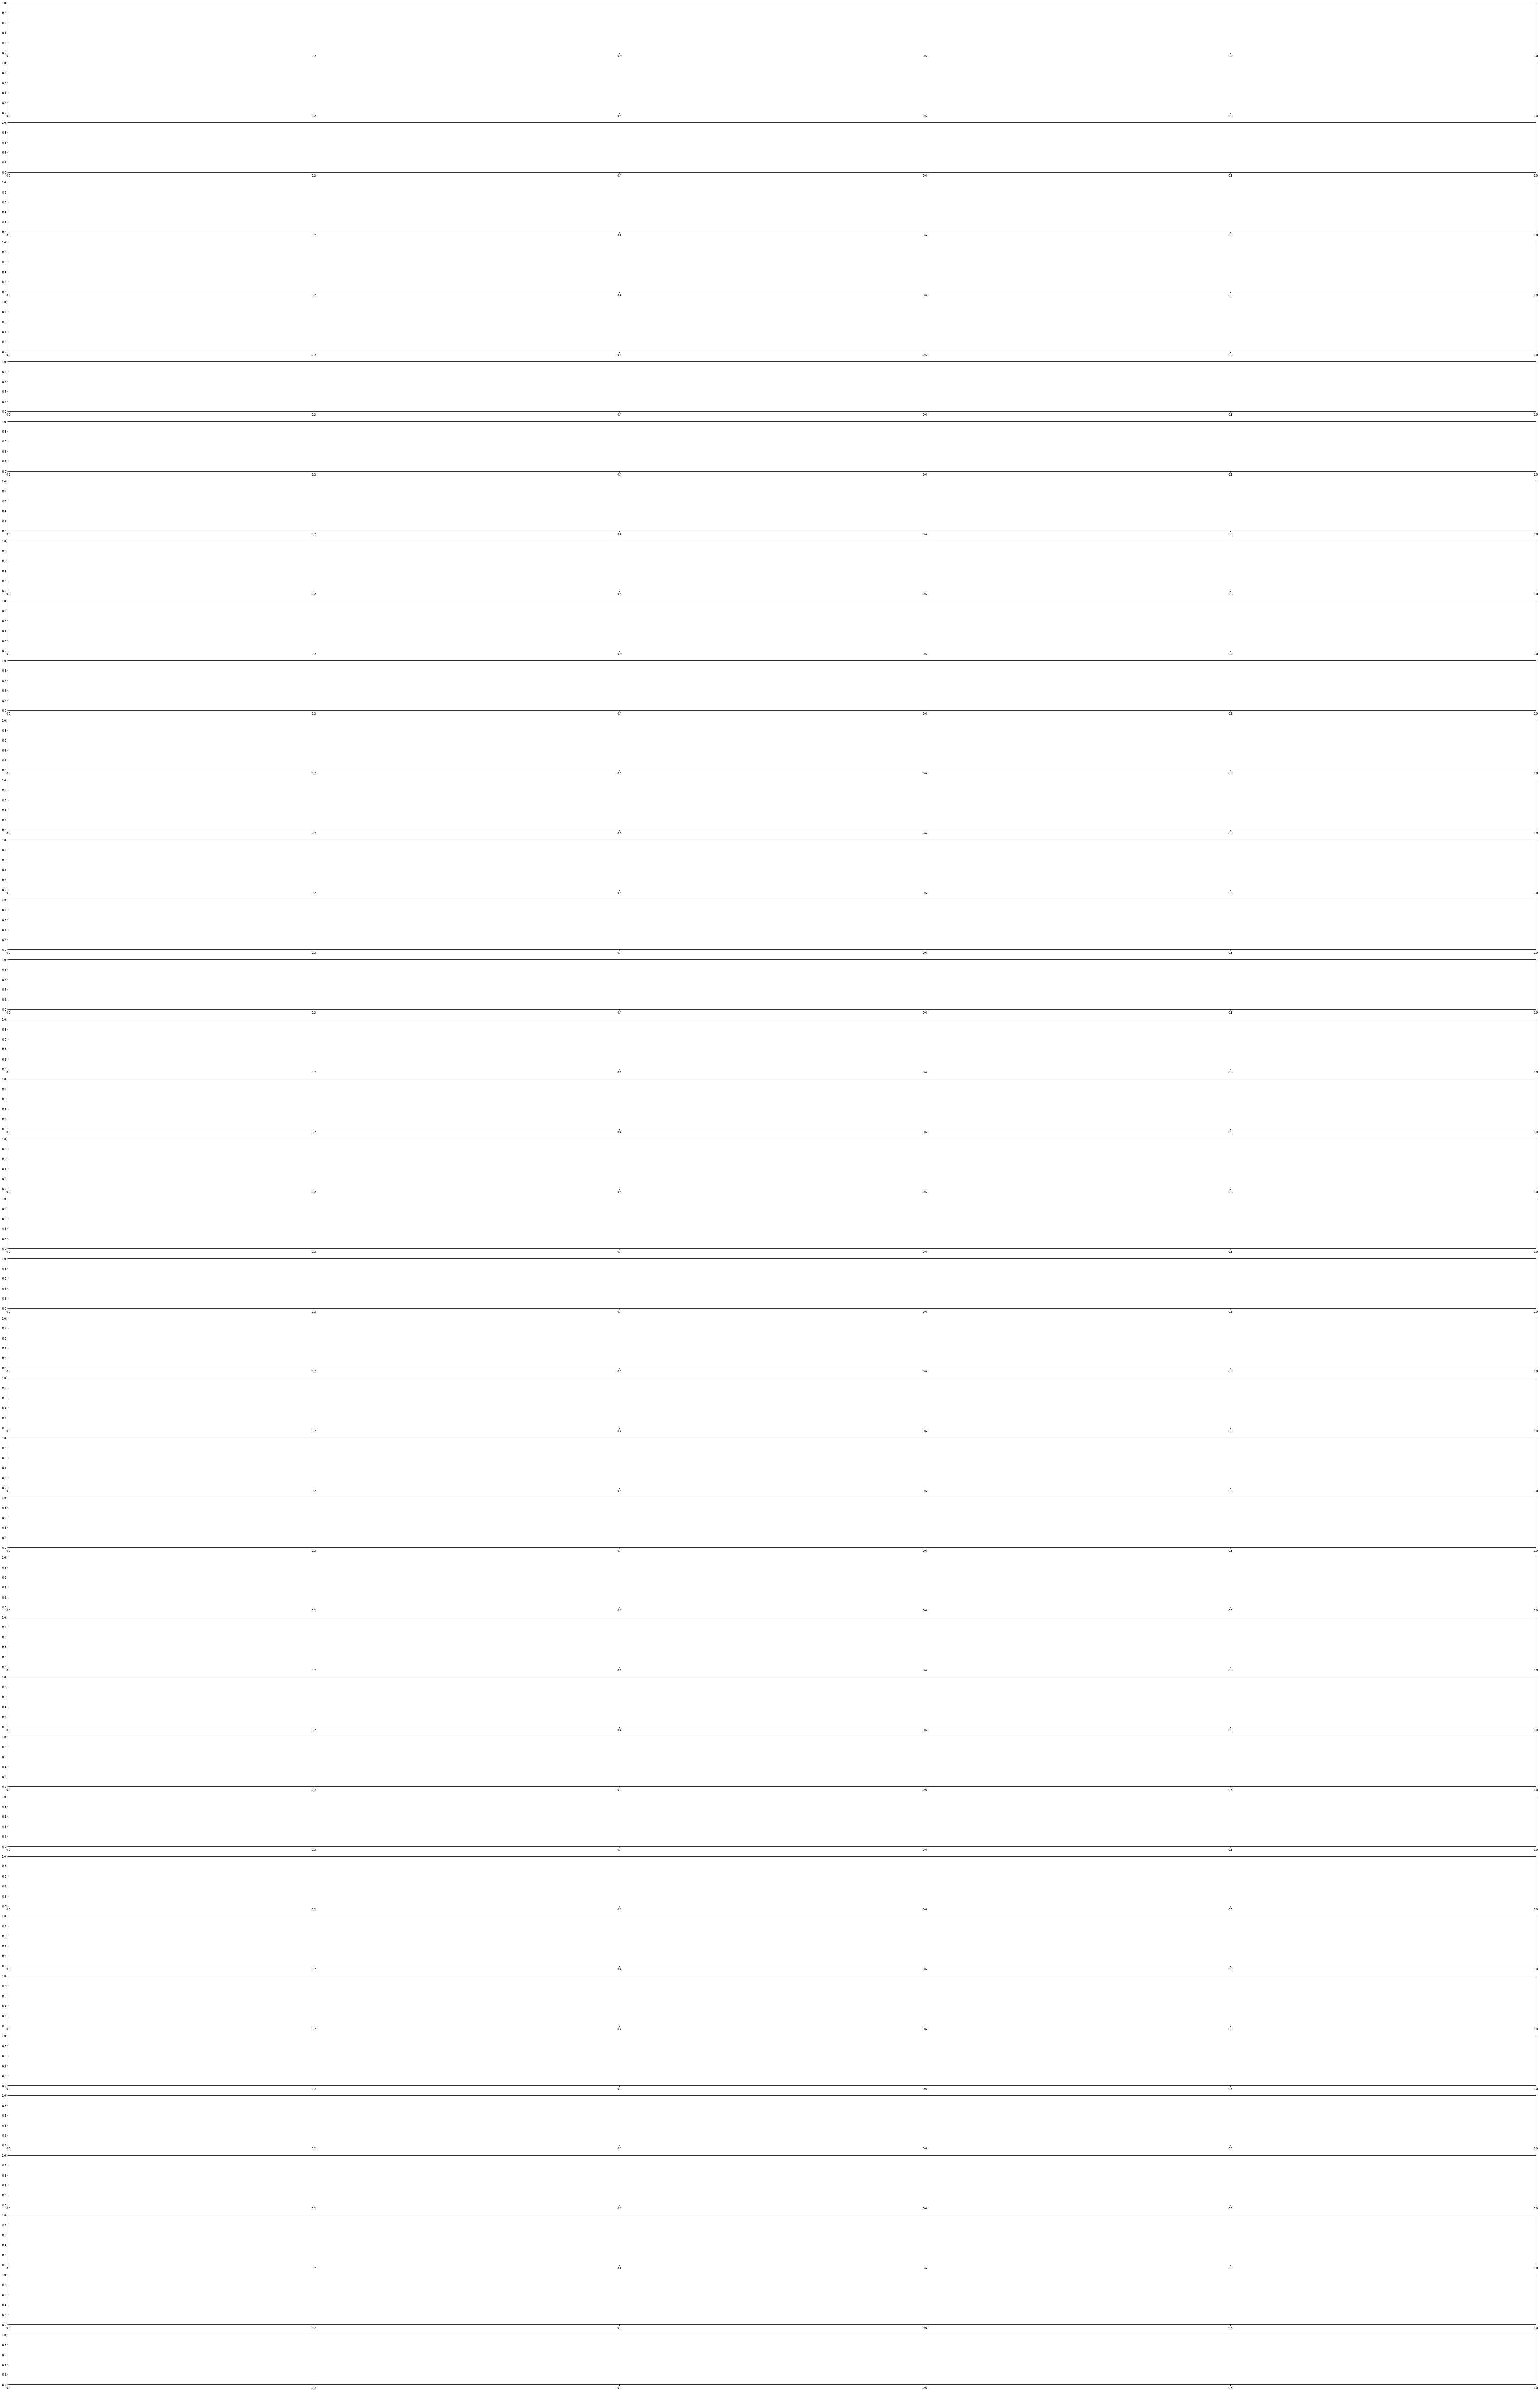

In [18]:
df_zendo = pd.read_csv('main_data_formatted.csv')  # getting the preprocessed data file



df_zendo = df_zendo.query("rule_name == 'Zeta' or rule_name == 'Upsilon' or rule_name == 'Iota' or rule_name == 'Kappa' or rule_name == 'Omega'")
df_zendo = df_zendo.reset_index(drop=True)
print(len(df_zendo['data']))
# plotting prior and posterior accuracy
token_ids = df_zendo['token_id']
token_ids = list(dict.fromkeys(token_ids))
# from matplotlib.backends.backend_pdf import PdfPages
# pp = PdfPages('multipage.pdf')


fig, ax = plt.subplots(40,1,figsize=(100,160))
x = np.arange(5)
width = 0.05

prior_acc_zeta = []
prior_acc_kappa = []
prior_acc_iota = []
prior_acc_omega = []
prior_acc_upsilon = []
post_acc_zeta = []
post_acc_kappa = []
post_acc_iota = []
post_acc_omega = []
post_acc_upsilon = []

  

prior_acc = []
feedback_1 = []
post_acc = []
feedback_2 = []
names = []
prior_match_perc = []
posterior_match_perc = []

prior_alone_perc = []
posterior_alone_perc = []

prior_match_acc = []
posterior_match_acc = []
prior_alone_acc = []
posterior_alone_acc = []

d_low_acc = []
d_high_acc = []
# plt.rcParams.update({'font.size': 25})
print(df_zendo)

for subj in range(0, 40):  
    names.append(df_zendo['rule_description'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    prior_acc.append(df_zendo['prior_accuracy'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    feedback_1.append(df_zendo['prior_feedback'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    feedback_2.append(df_zendo['posterior_feedback'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    post_acc.append(df_zendo['posterior_accuracy'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    prior_alone_perc.append(df_zendo['prior_alone_perc'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    posterior_alone_perc.append(df_zendo['posterior_alone_perc'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    prior_match_perc.append(df_zendo['prior_match_perc'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    posterior_match_perc.append(df_zendo['posterior_match_perc'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    prior_match_acc.append(df_zendo['prior_match_acc'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    posterior_match_acc.append(df_zendo['posterior_match_acc'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    prior_alone_acc.append(df_zendo['prior_alone_acc'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    posterior_alone_acc.append(df_zendo['posterior_alone_acc'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    
    d_low_acc.append(df_zendo['delta_low_acc'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    d_high_acc.append(df_zendo['delta_high_acc'].loc[df_zendo['token_id'] == token_ids[subj]].tolist())
    
    
#     if df_zendo['rule_name'][subj] == 'Zeta':
#         prior_acc_zeta.append(df_zendo['prior_accuracy'][subj])
#         print(df_zendo['prior_accuracy'][subj])
#         print(df_zendo['posterior_accuracy'][subj])
#         post_acc_zeta.append(df_zendo['posterior_accuracy'][subj])
#     elif df_zendo['rule_name'][subj] == 'Kappa':
#         prior_acc_kappa.append(df_zendo['prior_accuracy'][subj])
#         post_acc_kappa.append(df_zendo['posterior_accuracy'][subj])
#     elif df_zendo['rule_name'][subj] == 'Iota':
#         prior_acc_iota.append(df_zendo['prior_accuracy'][subj])
#         post_acc_iota.append(df_zendo['posterior_accuracy'][subj])
#     elif df_zendo['rule_name'][subj] == 'Omega':
#         prior_acc_omega.append(df_zendo['prior_accuracy'][subj])
#         post_acc_omega.append(df_zendo['posterior_accuracy'][subj])
#     elif df_zendo['rule_name'][subj] == 'Upsilon':
#         prior_acc_upsilon.append(df_zendo['prior_accuracy'][subj])
#         post_acc_upsilon.append(df_zendo['posterior_accuracy'][subj])


#     prior_a_rect = ax[subj].bar(x - 0.275, prior_acc[subj], width, label="prior_accuracy")
#     post_a_rect = ax[subj].bar(x - 0.225, post_acc[subj], width, label="posterior_accuracy")
#     prior_ap_rect = ax[subj].bar(x - 0.175, prior_alone_perc[subj], width, label="prior_alone_perc")
#     post_ap_rect = ax[subj].bar(x - 0.125, posterior_alone_perc[subj], width, label="post_alone_perc")
#     prior_mp_rect = ax[subj].bar(x - 0.075, prior_match_perc[subj], width, label="prior_union_perc")
#     post_mp_rect = ax[subj].bar(x - 0.025, posterior_match_perc[subj], width, label="post_union_perc")
#     prior_ap_a_rect = ax[subj].bar(x + 0.025, prior_alone_acc[subj], width, label="prior_alone_accuracy")
#     post_ap_a_rect = ax[subj].bar(x + 0.075, posterior_alone_acc[subj], width, label="post_alone_accuracy")
#     prior_mp_a_rect = ax[subj].bar(x + 0.125, prior_match_acc[subj], width, label="prior_union_accuracy")
#     post_mp_a_rect = ax[subj].bar(x + 0.175, posterior_match_acc[subj], width, label="posterior_union_accuracy")
#     d_low_a_rect = ax[subj].bar(x + 0.225, d_low_acc[subj], width, label="d_low_accuracy")
#     d_high_a_rect = ax[subj].bar(x + 0.275, d_high_acc[subj], width, label="d_high_accuracy")

    
    
    
#     ax[subj].set_ylabel('percentage', size=30, color="red")
#     ax[subj].set_title("id: " + token_ids[subj] + ", room: " + df_zendo['room'].loc[df_zendo['token_id'] == token_ids[subj]].tolist()[0], color="red", size=50)
#     ax[subj].set_xticks(x)
#     ax[subj].set_xticklabels(names[subj])
#     ax[subj].tick_params(axis='x', colors='red')
#     ax[subj].tick_params(axis='y', colors='red')
#     ax[subj].legend()
#     fig.tight_layout()
for subj in range(0, len(df_zendo['token_id'])):
    if df_zendo['rule_name'][subj] == 'Zeta':
        prior_acc_zeta.append(df_zendo['prior_accuracy'][subj])
        post_acc_zeta.append(df_zendo['posterior_accuracy'][subj])
    elif df_zendo['rule_name'][subj] == 'Kappa':
        prior_acc_kappa.append(df_zendo['prior_accuracy'][subj])
        post_acc_kappa.append(df_zendo['posterior_accuracy'][subj])
    elif df_zendo['rule_name'][subj] == 'Iota':
        print(df_zendo['prior_accuracy'][subj])
        print(df_zendo['posterior_accuracy'][subj])
        prior_acc_iota.append(df_zendo['prior_accuracy'][subj])
        post_acc_iota.append(df_zendo['posterior_accuracy'][subj])
    elif df_zendo['rule_name'][subj] == 'Omega':
        prior_acc_omega.append(df_zendo['prior_accuracy'][subj])
        post_acc_omega.append(df_zendo['posterior_accuracy'][subj])
    elif df_zendo['rule_name'][subj] == 'Upsilon':
        prior_acc_upsilon.append(df_zendo['prior_accuracy'][subj])
        post_acc_upsilon.append(df_zendo['posterior_accuracy'][subj])
# #       

# plt.show()
# 
# print(np.mean(prior_acc))


In [9]:

print(np.mean(prior_acc_zeta))

0.825


In [1]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0,0,1,1])
x = np.arange(1)
plt.rcParams.update({'font.size': 10})

width = 0.05
prior_a_rect = ax.bar(x - 0.225, np.mean([acc for sublist in prior_acc for acc in sublist]), width, label="prior_accuracy")
post_a_rect = ax.bar(x - 0.175, np.mean([acc for sublist in post_acc for acc in sublist]), width, label="posterior_accuracy")

# prior_ap_rect = ax.bar(x - 0.125, np.mean(prior_alone_perc), width, label="prior_alone_perc")
# post_ap_rect = ax.bar(x - 0.075, np.mean(posterior_alone_perc), width, label="post_alone_perc")
                      
prior_mp_rect = ax.bar(x - 0.025, np.mean([acc for sublist in prior_match_perc for acc in sublist]), width, label="prior_union_perc")
post_mp_rect = ax.bar(x + 0.025, np.mean([acc for sublist in posterior_match_perc for acc in sublist]), width, label="post_union_perc")

# prior_ap_a_rect = ax.bar(x + 0.075, np.mean(prior_alone_acc), width, label="prior_alone_accuracy")
# post_ap_a_rect = ax.bar(x + 0.125, np.mean(posterior_alone_acc), width, label="post_alone_accuracy")

prior_mp_a_rect = ax.bar(x + 0.175, np.mean([acc for sublist in prior_match_acc for acc in sublist]), width, label="prior_union_accuracy")
post_mp_a_rect = ax.bar(x + 0.225, np.mean([acc for sublist in posterior_match_acc for acc in sublist]), width, label="posterior_union_accuracy")

d_low_a_rect = ax.bar(x + 0.375, np.mean([acc for sublist in d_low_acc for acc in sublist]), width, label="delta_low_accuracy")
d_high_a_rect = ax.bar(x + 0.425, np.mean([acc for sublist in d_high_acc for acc in sublist]), width, label="delta_high_accuracy")

acc_values = [np.mean([acc for sublist in prior_acc for acc in sublist]), 
              np.mean([acc for sublist in post_acc for acc in sublist]),
              np.mean([acc for sublist in prior_match_perc for acc in sublist]),
              np.mean([acc for sublist in posterior_match_perc for acc in sublist]),
              np.mean([acc for sublist in prior_match_acc for acc in sublist]),
              np.mean([acc for sublist in posterior_match_acc for acc in sublist]),
              np.mean([acc for sublist in d_low_acc for acc in sublist]),
              np.mean([acc for sublist in d_high_acc for acc in sublist])]
print(len([acc for sublist in prior_acc for acc in sublist]))

rects = [prior_a_rect,
         post_a_rect,
         prior_mp_rect,
         post_mp_rect,
         prior_mp_a_rect,
         post_mp_a_rect,
         d_low_a_rect,
         d_high_a_rect]

def autolabel(rects, ind, sign = 1, mult=1.01):
   
    i = 0
    for rect in rects:
        height = rects[i].get_height()
        ax.text(rects[i].get_x() + rect.get_width()/2., mult*sign*height,
                round(acc_values[ind],5),
                ha='center', va='bottom')
        i+= 1

autolabel(rects[0],0)
autolabel(rects[1],1)
autolabel(rects[2],2)
autolabel(rects[3],3)
autolabel(rects[4],4)
autolabel(rects[5],5)
autolabel(rects[6],6)
autolabel(rects[7],7, sign = -1, mult=-0.105)


ax.set_ylabel('percentage', size=15, color="black")
plt.tick_params(
    axis='x',          # changes apply to the x-axis\n",
    which='both',      # both major and minor ticks are affected\n",
    bottom=False,      # ticks along the bottom edge are off\n",
    top=False,         # ticks along the top edge are off\n",
    labelbottom=False)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.legend()
fig.tight_layout()
plt.savefig('class_frequencies.pdf')  


NameError: name 'plt' is not defined

In [11]:
print(len([acc for sublist in prior_acc for acc in sublist]))

104


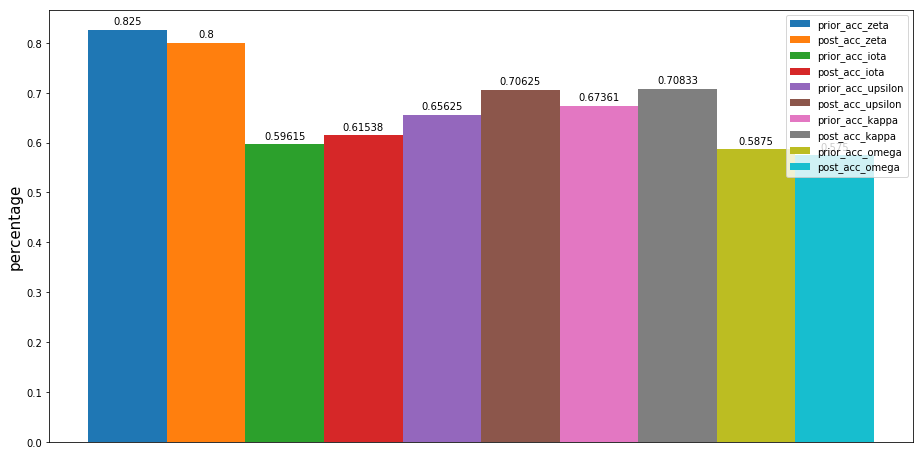

In [15]:
# specific rules 
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0,0,1,1])
x = np.arange(1)
plt.rcParams.update({'font.size': 10})

width = 0.05
# print(len(prior_acc))

acc_values = [np.mean(prior_acc_zeta), 
              np.mean(post_acc_zeta),
              np.mean(prior_acc_iota), 
              np.mean(post_acc_iota),
              np.mean(prior_acc_upsilon), 
              np.mean(post_acc_upsilon),
              np.mean(prior_acc_kappa), 
              np.mean(post_acc_kappa),
              np.mean(prior_acc_omega), 
              np.mean(post_acc_omega)]

prior_acc_zeta_rect = ax.bar(x - 0.225, np.mean(prior_acc_zeta), width, label="prior_acc_zeta")
post_acc_zeta_rect = ax.bar(x - 0.175, np.mean(post_acc_zeta), width, label="post_acc_zeta")

prior_acc_iota_rect = ax.bar(x - 0.125, np.mean(prior_acc_iota), width, label="prior_acc_iota")
post_acc_iota_rect = ax.bar(x - 0.075, np.mean(post_acc_iota), width, label="post_acc_iota")

prior_acc_upsilon_rect = ax.bar(x - 0.025, np.mean(prior_acc_upsilon), width, label="prior_acc_upsilon")
post_acc_upsilon_rect = ax.bar(x + 0.025, np.mean(post_acc_upsilon), width, label="post_acc_upsilon")

prior_acc_kappa_rect = ax.bar(x + 0.075, np.mean(prior_acc_kappa), width, label="prior_acc_kappa")
post_acc_kappa_rect = ax.bar(x + 0.125, np.mean(post_acc_kappa), width, label="post_acc_kappa")

prior_acc_omega_rect = ax.bar(x + 0.175, np.mean(prior_acc_omega), width, label="prior_acc_omega")
post_acc_omega_rect = ax.bar(x + 0.225, np.mean(post_acc_omega), width, label="post_acc_omega")


# print(prior_match_perc)


# print(acc_values)
                       
rects = [prior_acc_zeta_rect,
         post_acc_zeta_rect,
         prior_acc_iota_rect,
         post_acc_iota_rect,
         prior_acc_upsilon_rect,
         post_acc_upsilon_rect,
         prior_acc_kappa_rect,
         post_acc_kappa_rect,
         prior_acc_omega_rect,
         post_acc_omega_rect]


# print(rects)

def autolabel(rects, ind, sign = 1, mult=1.01):
   
    i = 0
    for rect in rects:
#         print('hi')
        height = rects[i].get_height()
        ax.text(rects[i].get_x() + rect.get_width()/2., mult*sign*height,
                round(acc_values[ind],5),
                ha='center', va='bottom')
        i+= 1

autolabel(rects[0],0)
autolabel(rects[1],1)
autolabel(rects[2],2)
autolabel(rects[3],3)
autolabel(rects[4],4)
autolabel(rects[5],5)
autolabel(rects[6],6)
autolabel(rects[7],7)
autolabel(rects[8],8)
autolabel(rects[9],9)



ax.set_ylabel('percentage', size=15, color="black")
plt.tick_params(
    axis='x',          # changes apply to the x-axis\n",
    which='both',      # both major and minor ticks are affected\n",
    bottom=False,      # ticks along the bottom edge are off\n",
    top=False,         # ticks along the top edge are off\n",
    labelbottom=False)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.legend()
fig.tight_layout()
plt.savefig('summary_res_exp_1_specific_rules.pdf')  


In [13]:

print(np.mean(post_acc))
print(np.std(prior_acc))

TypeError: unsupported operand type(s) for /: 'list' and 'int'

0.04807692307692308
-0.021634615384615384
0.14395979025359165
0.10939250233375652
WilcoxonResult(statistic=337.5, pvalue=0.00038048256308074687)
NormaltestResult(statistic=74.05591979551772, pvalue=8.297768997095663e-17)
NormaltestResult(statistic=16.488933174568043, pvalue=0.0002627082158053166)


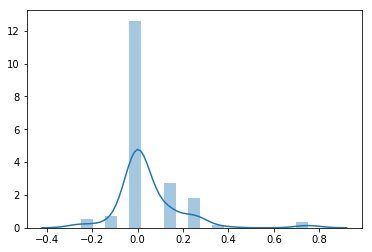

In [24]:
from scipy import stats
from statistics import mean, stdev


prior_acc_list = [acc for sublist in d_low_acc for acc in sublist]
post_acc_list = [acc for sublist in d_high_acc for acc in sublist]
print(mean(prior_acc_list))
print(mean(post_acc_list))
print(stdev(prior_acc_list))
print(stdev(post_acc_list))
print(stats.wilcoxon(prior_acc_list,post_acc_list))
print(stats.normaltest(prior_acc_list))
print(stats.normaltest(post_acc_list))
import seaborn as sns
sns.distplot(prior_acc_list)
# sns.distplot(post_acc_list)

In [16]:
from statistics import stdev
print(np.mean(d_low_acc))
print(np.mean(d_high_acc))
print(post_match_perc)

print(stdev([acc for sublist in d_low_acc for acc in sublist]))
print(stdev([acc for sublist in d_high_acc for acc in sublist]))

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [14]:
print(isinstance(False, str))

False


In [15]:
import math
math.e**(.5/float('inf')) / (math.e**(.5/float('inf')) + math.e**((1-.5)/float('inf')))

0.5

In [16]:
math.e**(.5/100000) / (math.e**(.5/100000) + math.e**((1-.5)/100000))

0.5

In [17]:
df_zendo['rule_name'].value_counts()[0]
print(df_zendo['rule_name'].mode()[0])
print(isinstance(df_zendo['rule_name'].mode()[0], str))

Iota
True


In [18]:
e = [1,6]
d = [1,1]
print(e+d)

[1, 6, 1, 1]


In [19]:
k = [[1,3],[4,4]]
print(np.mean(k))

3.0


In [72]:
dl =[i for sublist in d_low_acc for i in sublist]
dh =[i for sublist in d_high_acc for i in sublist]
pma =[i for sublist in prior_match_acc for i in sublist]
poma =[i for sublist in posterior_match_acc for i in sublist]
pmp =[i for sublist in prior_match_perc for i in sublist]
pomp =[i for sublist in posterior_match_perc for i in sublist]


print(stats.wilcoxon(pmp,pomp))
print(stats.wilcoxon(pma,poma))
print(stats.wilcoxon(dl,dh))
print(np.mean(pmp))
print(np.mean(pomp))
print(np.mean(pma))
print(np.mean(poma))
print(np.mean(dl))
print(np.mean(dh))

print(np.std(pmp))
print(np.std(pomp))
print(np.std(pma))
print(np.std(poma))
print(np.std(dl))
print(np.std(dh))

WilcoxonResult(statistic=607.0, pvalue=2.0794003525263947e-15)
WilcoxonResult(statistic=799.0, pvalue=1.0729432276924753e-08)
WilcoxonResult(statistic=831.0, pvalue=5.119757033789223e-12)
0.59125
0.71125
0.45875
0.5275
0.058125
-0.040625
0.2255929686404255
0.21042739246590497
0.23187752694040878
0.23088146309307725
0.1494142207923998
0.12179484543690672


0.59125


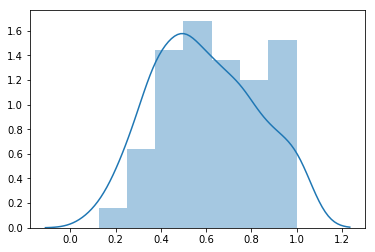

In [21]:
import seaborn as sns
sns.distplot(pmp)
print(np.mean(pmp))

0.71125


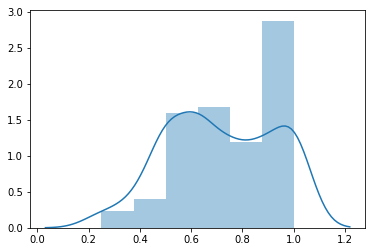

In [22]:
sns.distplot(pomp)
print(np.mean(pomp))

In [23]:
print(np.mean(pma))

0.45875


In [24]:
print(stats.mode(dl))
print(stats.mode(dh))

ModeResult(mode=array([0.]), count=array([117]))
ModeResult(mode=array([0.]), count=array([151]))


In [25]:
print([1,1,1,1,0,0,0,0] * 5)

[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]


ValueError: not enough values to unpack (expected 2, got 1)

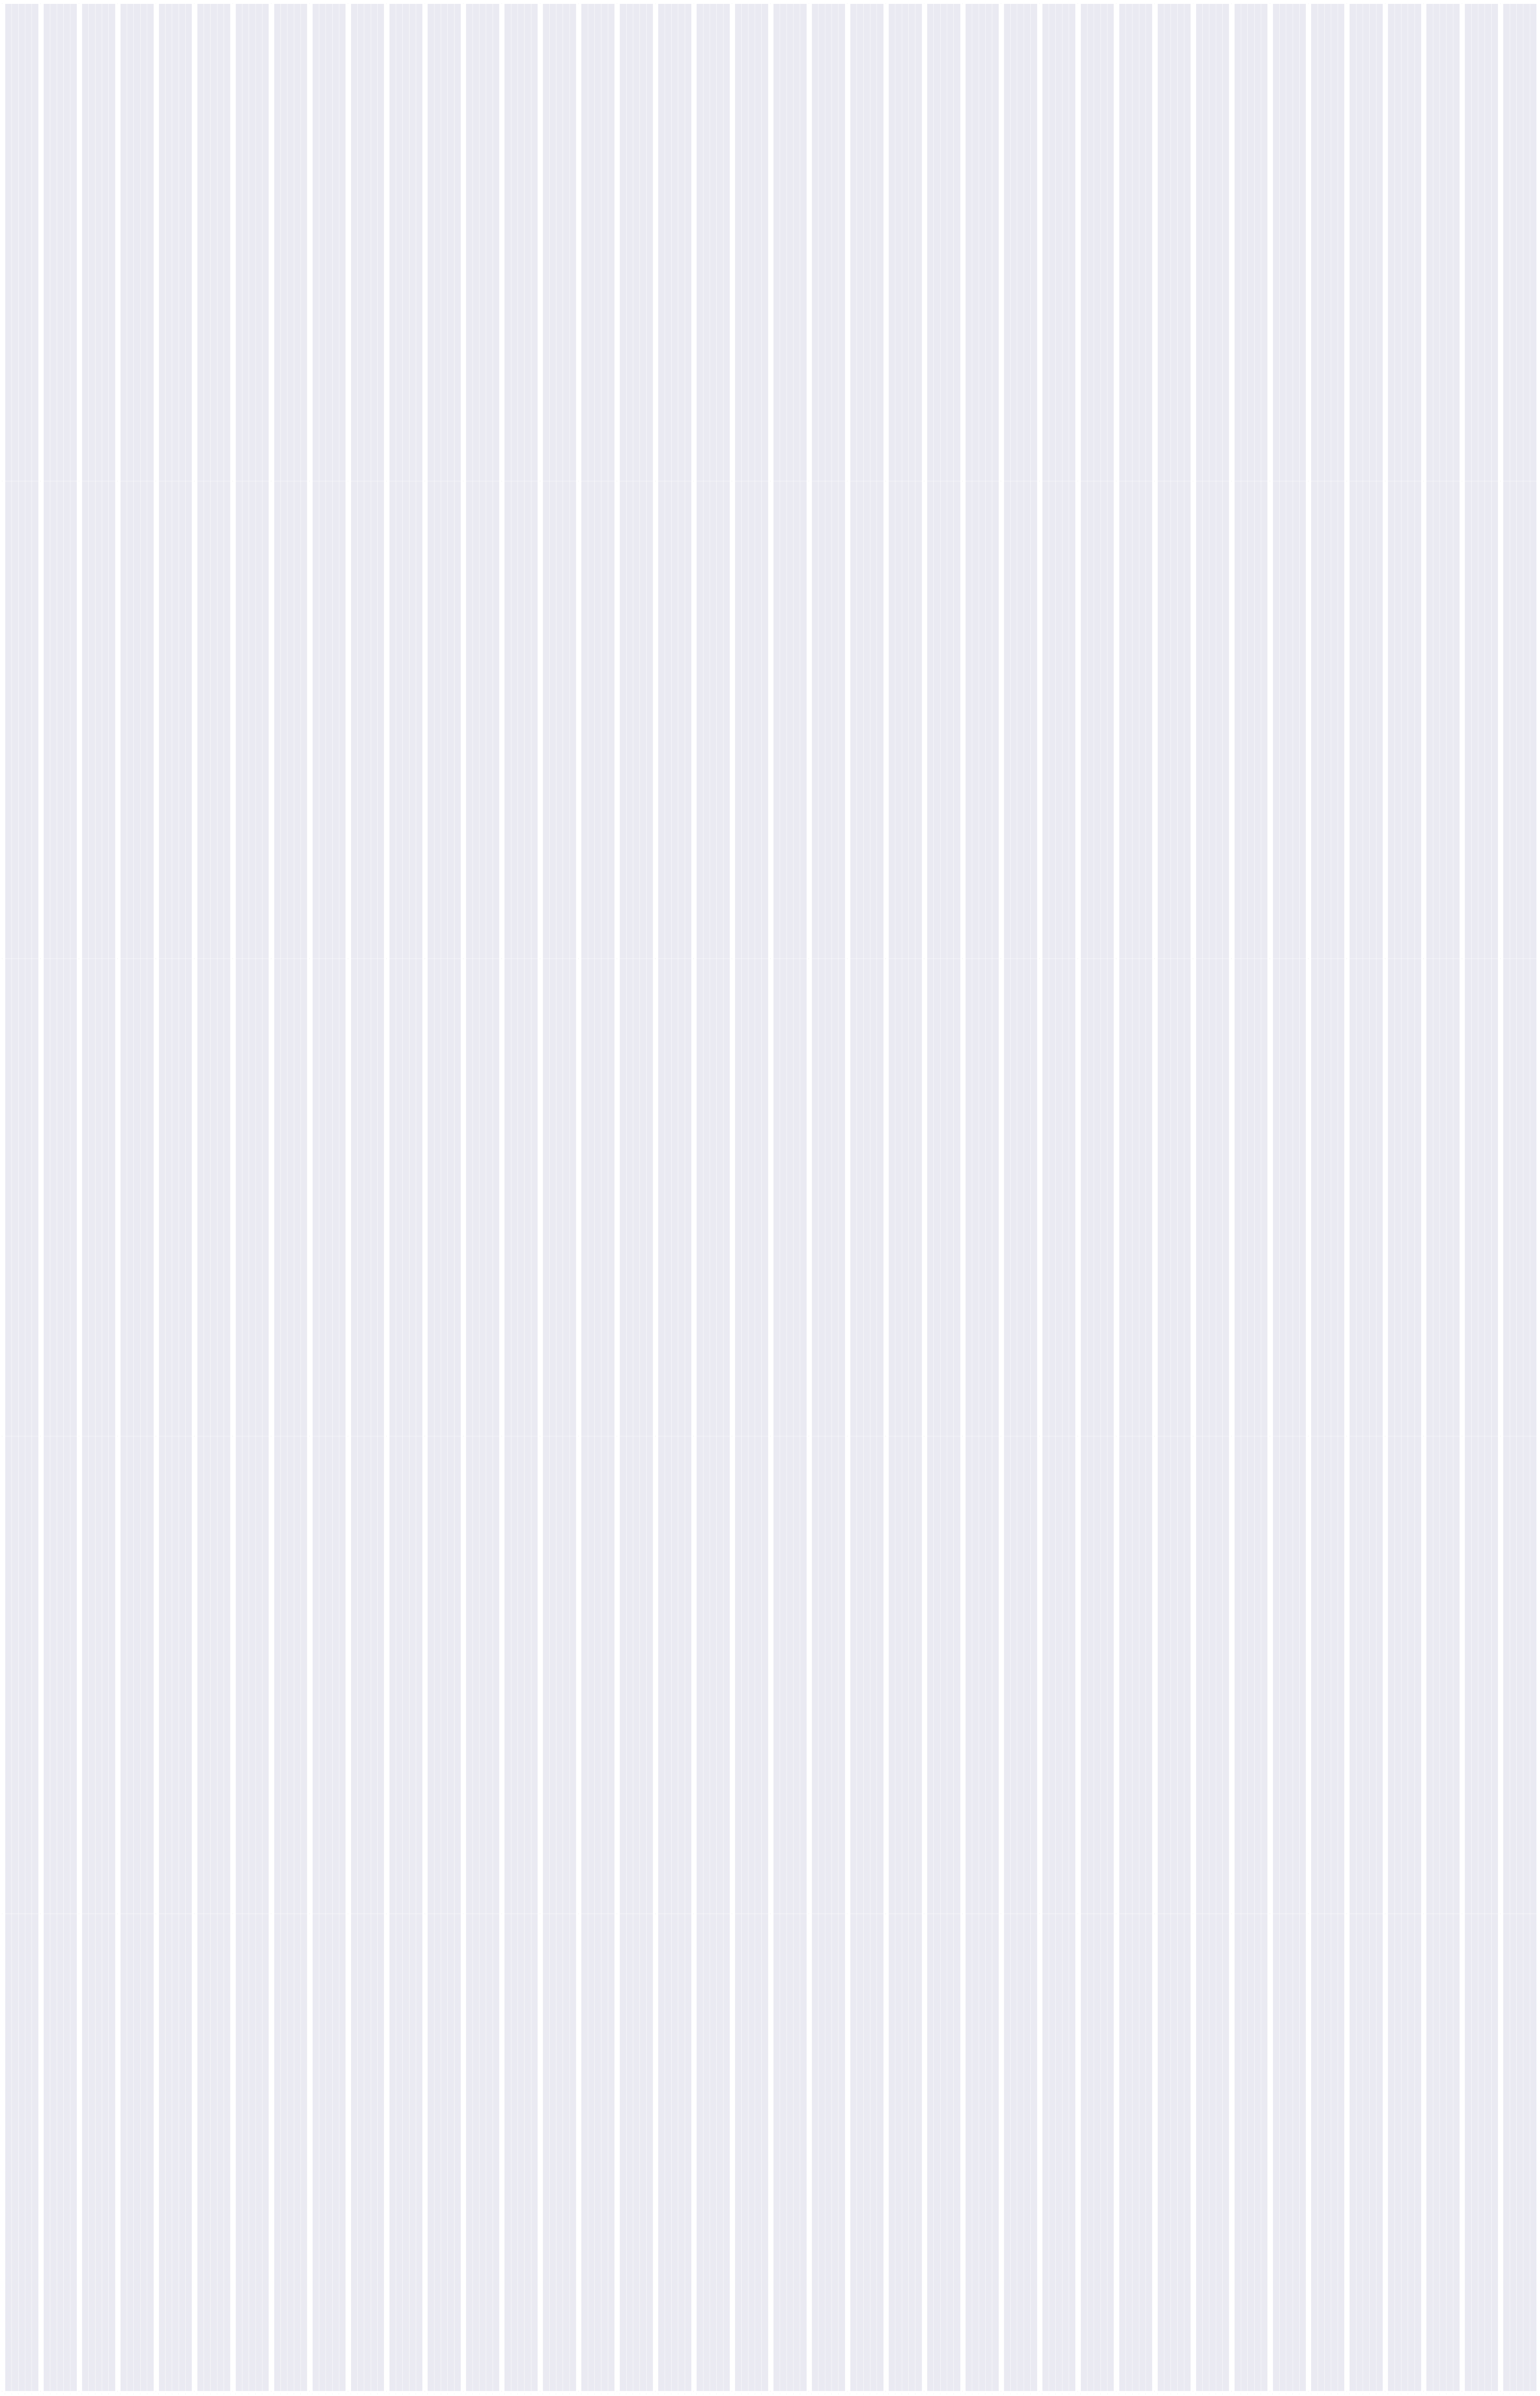

0.6634615384615384
0.22715855303088608
0.6766826923076923
0.22211648585768792
WilcoxonResult(statistic=192.0, pvalue=0.3940338990014881)
NormaltestResult(statistic=11.744986854394169, pvalue=0.00281584347273619)
NormaltestResult(statistic=8.278064910642835, pvalue=0.015938265030187675)


TypeError: len() takes exactly one argument (0 given)

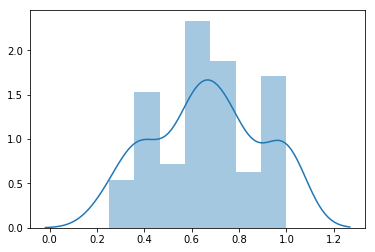

In [10]:
from scipy import stats
from statistics import mean, stdev 
prior_acc_list = [acc for sublist in prior_acc for acc in sublist]

post_acc_list = [acc for sublist in post_acc for acc in sublist]
print(mean(prior_acc_list))
print(stdev(prior_acc_list))
print(mean(post_acc_list))
print(stdev(post_acc_list))
print(stats.wilcoxon(prior_acc_list,post_acc_list))
print(stats.normaltest(prior_acc_list))
print(stats.normaltest(post_acc_list))
import seaborn as sns
sns.distplot(prior_acc_list)
# sns.distplot(post_acc_list)
print(len())

In [11]:
from statistics import mean, stdev
age = []
time = []
for i in debrief_data:
    age.append(i['age'])
    
print(mean(age))
print(stdev(age))
# print(mean(time))
# print(stdev(time))

37.675
10.875489968331635
